In [18]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [19]:
dataset_path = './dataset/'

img_size = (224, 224)
batch_size = 32

train_dataset_full = image_dataset_from_directory(
    os.path.join(dataset_path, 'train'),
    shuffle=True,
    batch_size=batch_size,
    image_size=img_size,
    color_mode="rgb"
)


test_dataset = image_dataset_from_directory(
    os.path.join(dataset_path, 'test'),
    shuffle=False,
    batch_size=batch_size,
    image_size=img_size,
    color_mode="rgb"
)

train_dataset_percent = 1.0

num_batches = tf.data.experimental.cardinality(train_dataset_full).numpy()
percent_batches = max(1, int(train_dataset_percent * num_batches))
train_dataset = train_dataset_full.take(percent_batches)

from tensorflow.keras.applications.mobilenet_v3 import preprocess_input
train_dataset = train_dataset.map(lambda x, y: (preprocess_input(x), y))
test_dataset = test_dataset.map(lambda x, y: (preprocess_input(x), y))

train_dir = os.path.join(dataset_path, 'train')
class_names = sorted(os.listdir(train_dir))
num_classes = len(class_names)
print("Classes:", class_names)

Found 5812 files belonging to 5 classes.
Found 1456 files belonging to 5 classes.
Classes: ['biological', 'glass', 'other', 'paper', 'plastic']


Found 5812 files belonging to 5 classes.


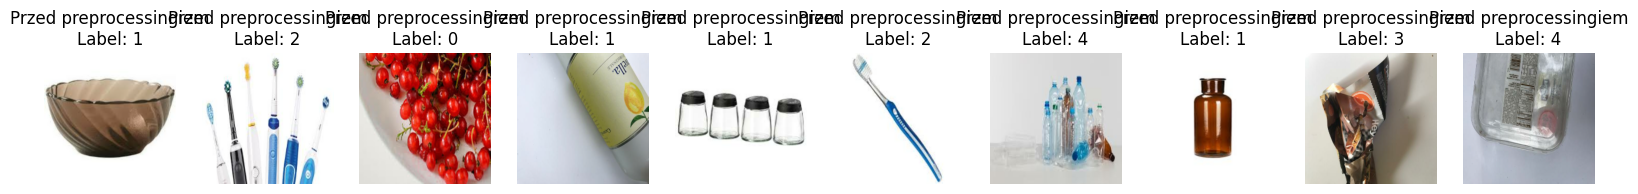

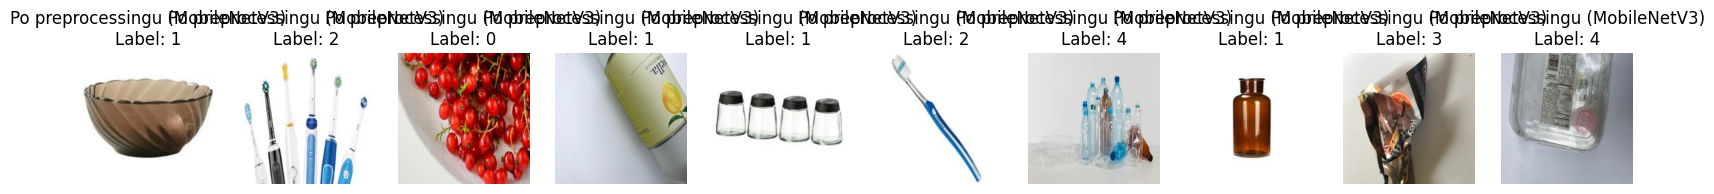

In [20]:
raw_dataset = image_dataset_from_directory(
    os.path.join(dataset_path, 'train'),
    shuffle=True,
    batch_size=10,
    image_size=img_size,
)

for images, labels in raw_dataset.take(1):
    raw_images = images
    raw_labels = labels

processed_images = preprocess_input(tf.identity(raw_images))

def show_images(images, title, n=10):
    plt.figure(figsize=(20, 4))
    for i in range(n):
        ax = plt.subplot(1, n, i + 1)
        img = images[i].numpy()
        if img.shape[-1] == 3:
            img = (img - img.min()) / (img.max() - img.min()) 
        plt.imshow(img)
        plt.axis("off")
        plt.title(title + f"\nLabel: {raw_labels[i].numpy()}")

show_images(raw_images, "Przed preprocessingiem")
show_images(processed_images, "Po preprocessingu (MobileNetV3)")

In [21]:
def count_images_per_class(directory):
    class_counts = {}
    for class_name in sorted(os.listdir(directory)):
        class_dir = os.path.join(directory, class_name)
        if os.path.isdir(class_dir):
            count = len([f for f in os.listdir(class_dir) if os.path.isfile(os.path.join(class_dir, f))])
            class_counts[class_name] = count
    return class_counts

train_counts = count_images_per_class(os.path.join(dataset_path, 'train'))
test_counts = count_images_per_class(os.path.join(dataset_path, 'test'))

train_total = sum(train_counts.values())
test_total = sum(test_counts.values())
grand_total = train_total + test_total

print(f"Number of images: {train_total + test_total }\n")

print(f"Train ({train_total}):\n")
for cls in class_names:
   print(f"{cls}: {train_counts.get(cls, 0)}\n")

print(f"Test ({test_total }):\n")
for cls in class_names:
  print(f"{cls}: {test_counts.get(cls, 0)}\n")

Number of images: 7269

Train (5813):

biological: 788

glass: 1608

other: 557

paper: 1552

plastic: 1308

Test (1456):

biological: 197

glass: 403

other: 140

paper: 389

plastic: 327



In [22]:
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input

base_model = tf.keras.applications.MobileNetV3Large(input_shape=img_size + (3,), include_top=False, weights='imagenet')
base_model.trainable = False
fine_tune_at = 100

for layer in base_model.layers[fine_tune_at:]:
    layer.trainable = True

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(200, activation='relu'),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(25, activation='relu'),
    tf.keras.layers.Dense(7, activation='relu'),
        
    tf.keras.layers.Dense(len(class_names), activation='softmax')
])

model.compile(optimizer='adam',
               loss='sparse_categorical_crossentropy',
               metrics=['accuracy'])

model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ MobileNetV3Large (Functional)   │ (None, 7, 7, 960)      │     2,996,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 960)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 200)            │       192,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 100)            │        20,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 7)              │           182 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 5)              │            40 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,215,199 (12.27 MB)

 Trainable params: 3,030,847 (11.56 MB)

 Non-trainable params: 184,352 (720.12 KB)

In [29]:
history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=100,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)]
)

Epoch 1/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 16s 82ms/step - accuracy: 0.9793 - loss: 0.0802 - val_accuracy: 0.8386 - val_loss: 1.8466
Epoch 2/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 14s 76ms/step - accuracy: 0.9800 - loss: 0.0661 - val_accuracy: 0.3571 - val_loss: 402.9208
Epoch 3/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 14s 76ms/step - accuracy: 0.9655 - loss: 0.1432 - val_accuracy: 0.6573 - val_loss: 24.3269
Epoch 4/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 14s 75ms/step - accuracy: 0.9692 - loss: 0.1248 - val_accuracy: 0.8709 - val_loss: 2.3989
Epoch 5/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 14s 75ms/step - accuracy: 0.9781 - loss: 0.0883 - val_accuracy: 0.9238 - val_loss: 2.1073
Epoch 6/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 14s 76ms/step - accuracy: 0.9849 - loss: 0.0531 - val_accuracy: 0.9299 - val_loss: 0.4075
Epoch 7/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 14s 76ms/step - accuracy: 0.9926 - loss: 0.0284 - val_accuracy: 0.9375 - val_loss: 0.2854
Epoch 8/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 14s 75ms/step - accuracy: 0.9889 - loss

In [30]:
from datetime import datetime

results_dir = './results/'

def get_data_folder():
    now = datetime.now()
    folder_name = now.strftime("%Y_%m_%d:%H-%M-%S")
    folder_path = os.path.join(results_dir, folder_name)
    os.makedirs(folder_path, exist_ok=True)
    return folder_path

data_folder = get_data_folder()

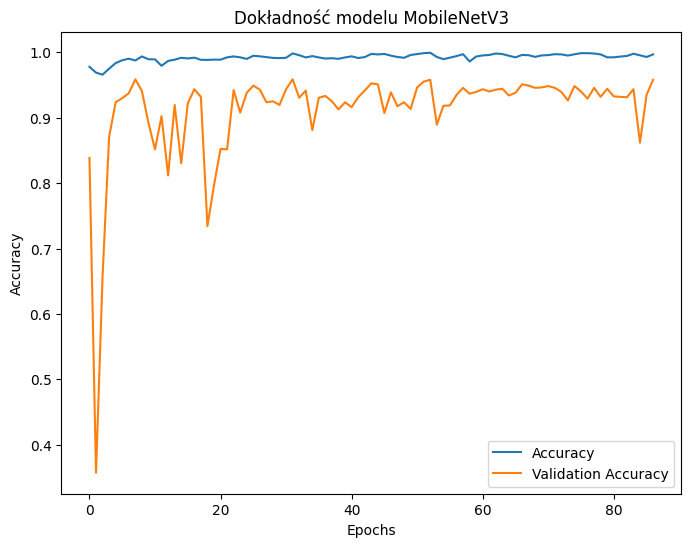

In [31]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.figure(figsize=(8, 6))
plt.plot(acc, label='Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Dokładność modelu MobileNetV3')

accuracy_path = os.path.join(data_folder, 'accuracy.png')
plt.savefig(accuracy_path)
plt.show()
plt.close()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms

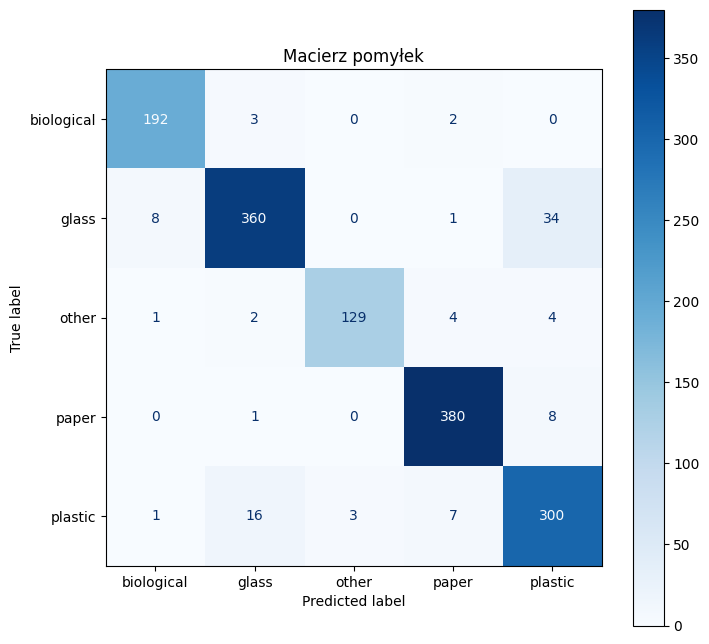

In [32]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

all_labels = []
all_pred_labels = []

for images, labels in test_dataset:
    preds = model.predict(images)
    pred_labels = np.argmax(preds, axis=1)

    all_labels.append(labels.numpy())
    all_pred_labels.append(pred_labels)

all_labels_np = np.concatenate(all_labels, axis=0)
all_pred_labels_np = np.concatenate(all_pred_labels, axis=0)

classes = class_names

cm = confusion_matrix(all_labels_np, all_pred_labels_np)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
fig, ax = plt.subplots(figsize=(8,8))
disp.plot(ax=ax, cmap=plt.cm.Blues, colorbar=True)
plt.title("Macierz pomyłek")

cm_path = os.path.join(data_folder, 'confusion_matrix.png')
plt.savefig(cm_path)
plt.show()
plt.close()

In [33]:
def count_images_per_class(directory):
    class_counts = {}
    for class_name in sorted(os.listdir(directory)):
        class_dir = os.path.join(directory, class_name)
        if os.path.isdir(class_dir):
            count = len([f for f in os.listdir(class_dir) if os.path.isfile(os.path.join(class_dir, f))])
            class_counts[class_name] = count
    return class_counts

train_counts = count_images_per_class(os.path.join(dataset_path, 'train'))
test_counts = count_images_per_class(os.path.join(dataset_path, 'test'))

In [34]:
import json


def save_model_summary_markdown(model, filepath):
    lines = []
    model.summary(print_fn=lambda x: lines.append(x))

    with open(filepath, 'w') as f:
        f.write("\n".join(lines))


def dataset_summary_markdown(filepath):
    train_total = sum(train_counts.values())
    test_total = sum(test_counts.values())
    grand_total = train_total + test_total

    with open(filepath, 'w') as f:
        f.write("# Dataset info\n\n")
        f.write(f"- Dataset path: `{dataset_path}`\n")
        f.write(f"- Percent of dataset used for training: {train_dataset_percent*100:.1f}%\n")
        f.write(f"- Number of classes: {num_classes}\n")
        f.write(f"- Classes: {class_names}\n")
        f.write(f"- Batch size: {batch_size}\n")
        f.write(f"- Image size: {img_size}\n")
        f.write(f"- Number of images: {train_total + test_total }\n")

        f.write("#\n\n")

        f.write(f"### Train ({train_total}):\n")
        for cls in class_names:
            f.write(f"- {cls}: {train_counts.get(cls, 0)}\n")

        f.write(f"### Test ({test_total }):\n")
        for cls in class_names:
          f.write(f"- {cls}: {test_counts.get(cls, 0)}\n")


def training_model_summary_markdown(filepath):
    with open(filepath, 'w') as f:
        f.write("# Training info\n\n")
        f.write(f"- Number of epochs: {len(history.history['loss'])}\n")
        f.write(f"- Optimizer: Adam (default)\n")
        f.write(f"- Loss function: sparse_categorical_crossentropy\n")
        f.write(f"- Metrics: accuracy\n")

save_model_summary_markdown(model, os.path.join(data_folder, 'model.md'))
dataset_summary_markdown(os.path.join(data_folder, 'dataset.md'))
training_model_summary_markdown(os.path.join(data_folder, 'training.md'))

In [35]:
model.save('model.keras')